# CS445: Computational Photography
## Programming Project 4: Image-Based Lighting


## Recovering HDR Radiance Maps 

Load libraries and data

In [1]:
# jupyter extension that allows reloading functions from imports without clearing kernel :D
%load_ext autoreload
%autoreload 2

In [2]:
# System imports
from os import path
import math

# Third-Party Imports
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

# modify to where you store your project data including utils
datadir = "./" 

utilfn = datadir + "utils"
#!cp -r "$utilfn" .
samplesfn = datadir + "samples"
#!cp -r "$samplesfn" .

# can change this to your output directory of choice
!mkdir "images"
!mkdir "images/outputs"

# import starter code
import utils
from utils.io import read_image, write_image, read_hdr_image, write_hdr_image
from utils.display import display_images_linear_rescale, rescale_images_linear
from utils.hdr_helpers import gsolve
from utils.hdr_helpers import get_equirectangular_image
from utils.bilateral_filter import bilateral_filter



mkdir: cannot create directory ‘images’: File exists
mkdir: cannot create directory ‘images/outputs’: File exists


### Reading LDR images

You can use the provided samples or your own images.  You get more points for using your own images, but it might help to get things working first with the provided samples.

In [3]:
# TODO: Replace this with your path and files

imdir = 'samples'
imfns = ['0024.jpg', '0060.jpg', '0120.jpg', '0205.jpg', '0553.jpg']
exposure_times = [1/24.0, 1/60.0, 1/120.0, 1/205.0, 1/553.0]

ldr_images = []
for f in np.arange(len(imfns)):
  im = read_image(imdir + '/' + imfns[f])
  if f==0:
    imsize = int((im.shape[0] + im.shape[1])/2) # set width/height of ball images
    ldr_images = np.zeros((len(imfns), imsize, imsize, 3))
  ldr_images[f] = cv2.resize(im, (imsize, imsize))

background_image_file = imdir + '/' + 'empty.jpg'
background_image = read_image(background_image_file)



### Naive LDR merging 

Compute the HDR image as average of irradiance estimates from LDR images

In [4]:
def make_hdr_naive(ldr_images: np.ndarray, exposures: list) -> (np.ndarray, np.ndarray):
    '''
    Makes HDR image using multiple LDR images, and its corresponding exposure values.
    
    The steps to implement:
    1) Divide each image by its exposure time.
        - This will rescale images as if it has been exposed for 1 second.
    
    2) Return average of above images
    
    
    For further explanation, please refer to problem page for how to do it.
      
    Args:
        ldr_images(np.ndarray): N x H x W x 3  shaped numpy array representing
            N ldr images with width W, height H, and channel size of 3 (RGB)
        exposures(list): list of length N, representing exposures of each images.
            Each exposure should correspond to LDR images' exposure value.
    Return:
        (np.ndarray): H x W x 3 shaped numpy array representing HDR image merged using
            naive ldr merging implementation.
        (np.ndarray): N x H x W x 3  shaped numpy array represending log irradiances
            for each exposures
            
    '''
    N, H, W, C = ldr_images.shape
    # sanity check
    assert N == len(exposures)
  
    # TO DO
    hdr_image=np.zeros((H,W,C))
    log_irradiances=np.zeros((N,H,W,C))
    for i in range(N):
        hdr_image+=ldr_images[i]/3/exposures[i]
        log_irradiances[i]=np.log(ldr_images[i]/exposures[i])
        #log_irradiances[i]=np.log1p(ldr_images[i]*255/exposures[i]) - np.log(exposures[i])

    return hdr_image, log_irradiances



In [5]:
def display_hdr_image(im_hdr):
    '''
    Maps the HDR intensities into a 0 to 1 range and then displays. 
    Three suggestions to try: 
      (1) Take log and then linearly map to 0 to 1 range (see display.py for example) 
      (2) img_out = im_hdr / (1 + im_hdr)
      (3) HDR display code in a python package 
    '''

    # TO DO
    # Approach (1)
    im_hdr=np.log(im_hdr)
    minim=np.min(im_hdr)
    maxim=np.max(im_hdr)
    im_hdr=(im_hdr-minim)/(maxim-minim)
    plt.imshow(im_hdr)
    plt.show()
    # Approach (2)
    im_hdr=im_hdr/(1+im_hdr)
    plt.imshow(im_hdr)
    plt.show()


HDR Image


/tmp/ipykernel_3702467/4143644876.py:35: RuntimeWarning: divide by zero encountered in log
  log_irradiances[i]=np.log(ldr_images[i]/exposures[i])


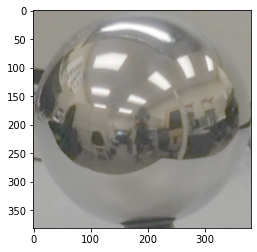

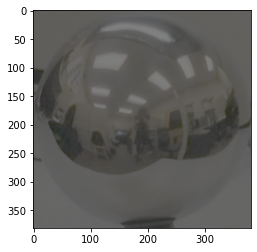

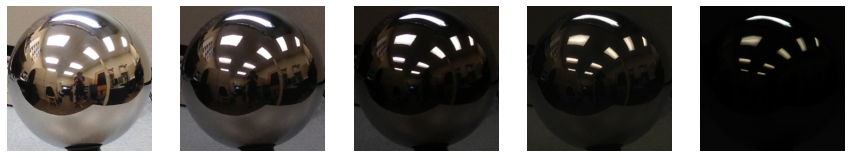

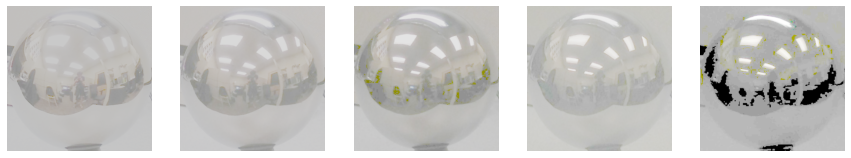

In [6]:

# get HDR image, log irradiance
naive_hdr_image, naive_log_irradiances = make_hdr_naive(ldr_images, exposure_times)

# write HDR image to directory
write_hdr_image(naive_hdr_image, 'images/outputs/naive_hdr.hdr')

# display HDR image
print('HDR Image')
display_hdr_image(naive_hdr_image)

# display original images (code provided in utils.display)
display_images_linear_rescale(ldr_images)

# display log irradiance image (code provided in utils.display)
display_images_linear_rescale(naive_log_irradiances)


### Weighted LDR merging 

Compute HDR image as a weighted average of irradiance estimates from LDR images, where weight is based on pixel intensity so that very low/high intensities get less weight


In [9]:
def make_hdr_weighted(ldr_images: np.ndarray, exposure_times: list) -> (np.ndarray, np.ndarray):
    '''
    Makes HDR image using multiple LDR images, and its corresponding exposure values.
    
    The steps to implement:
    1) compute weights for images with based on intensities for each exposures
        - This can be a binary mask to exclude low / high intensity values

    2) Divide each images by its exposure time.
        - This will rescale images as if it has been exposed for 1 second.
    
    3) Return weighted average of above images
    
    
    Args:
        ldr_images(np.ndarray): N x H x W x 3 shaped numpy array representing
            N ldr images with width W, height H, and channel size of 3 (RGB)
        exposure_times(list): list of length N, representing exposures of each images.
            Each exposure should correspond to LDR images' exposure value.
    Return:
        (np.ndarray): H x W x 3 shaped numpy array representing HDR image merged without
            under - over exposed regions

    '''
    N, H, W, C = ldr_images.shape
    # sanity check
    assert N == len(exposure_times)
    
    # TO DO
    hdr_image=np.zeros((H,W,C))
    log_irradiances=np.zeros((N,H,W,C))
    w=np.vectorize(lambda x:float(127-abs(x-127)))
    total_w=np.zeros((H,W,C))
    for i in range(N):
        total_w+=w(ldr_images[i])
        hdr_image+=w(ldr_images[i])*ldr_images[i]/exposure_times[i]/255
        log_irradiances[i]=np.log(ldr_images[i]/exposure_times[i])
        #log_irradiances[i]=np.log1p(ldr_images[i]*255/exposure_times[i]) - np.log(exposure_times[i])

    return hdr_image/total_w, log_irradiances


/tmp/ipykernel_3702467/3466270141.py:37: RuntimeWarning: divide by zero encountered in log
  log_irradiances[i]=np.log(ldr_images[i]/exposure_times[i])


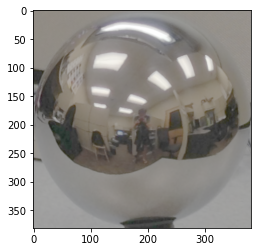

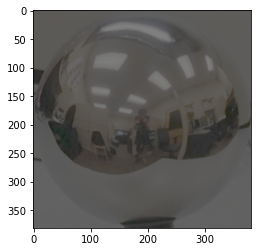

In [10]:
# get HDR image, log irradiance
weighted_hdr_image,weighted_log_irradiance = make_hdr_weighted(ldr_images, exposure_times)

# write HDR image to directory
write_hdr_image(weighted_hdr_image, 'images/outputs/weighted_hdr.hdr')

# display HDR image
display_hdr_image(weighted_hdr_image)


Display of difference between naive and weighted for your own inspection

Where does the weighting make a big difference increasing or decreasing the irradiance estimate?  Think about why.

Min ratio =  0.0017895811998888992   Max ratio =  0.006853935415464677


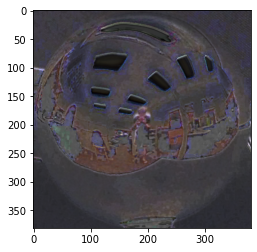

In [11]:
# display difference between naive and weighted 

log_diff_im = np.log(weighted_hdr_image)-np.log(naive_hdr_image)
print('Min ratio = ', np.exp(log_diff_im).min(), '  Max ratio = ', np.exp(log_diff_im).max())
plt.figure()
plt.imshow(rescale_images_linear(log_diff_im))

### LDR merging with camera response function estimation 

Compute HDR after calibrating the photometric reponses to obtain more accurate irradiance estimates from each image

Some suggestions on using <tt>gsolve</tt>:
<ul>
	<li>When providing input to gsolve, don't use all available pixels, otherwise you will likely run out of memory / have very slow run times. To overcome, just randomly sample a set of pixels (1000 or so can suffice), but make sure all pixel locations are the same for each exposure.</li>
	<li>The weighting function w should be implemented using Eq. 4 from the paper (this is the same function that can be used for the previous LDR merging method).</li>
	<li>Try different lambda values for recovering <i>g</i>. Try lambda=1 initially, then solve for <i>g</i> and plot it. It should be smooth and continuously increasing. If lambda is too small, g will be bumpy.</li>
	<li>Refer to Eq. 6 in the paper for using g and combining all of your exposures into a final image. Note that this produces log irradiance values, so make sure to exponentiate the result and save irradiance in linear scale.</li>
</ul>

In [14]:
def make_hdr_estimation(ldr_images: np.ndarray, exposure_times: list, lm)-> (np.ndarray, np.ndarray):
    '''
    Makes HDR image using multiple LDR images, and its corresponding exposure values.
    Please refer to problem notebook for how to do it.
    
    **IMPORTANT**
    The gsolve operations should be ran with:
        Z: int64 array of shape N x P, where N = number of images, P = number of pixels
        B: float32 array of shape N, log shutter times
        l: lambda; float to control amount of smoothing
        w: function that maps from float intensity to weight  
    The steps to implement:
    1) Create random points to sample (from mirror ball region)
    2) For each exposures, compute g values using samples
    3) Recover HDR image using g values
    

    Args:
        ldr_images(np.ndarray): N x H x W x 3 shaped numpy array representing
            N ldr images with width W, height H, and channel size of 3 (RGB)
        exposures(list): list of length N, representing exposures of each images.
            Each exposure should correspond to LDR images' exposure value.
        lm (scalar): the smoothing parameter
    Return:
        (np.ndarray): H x W x 3 shaped numpy array representing HDR image merged using
            gsolve
        (np.ndarray): N x H x W x 3 shaped numpy array represending log irradiances
            for each exposures
        (np.ndarray): 3 x 256 shaped numpy array represending g values of each pixel intensities
            at each channels (used for plotting)
    '''
    N, H, W, C = ldr_images.shape
    # sanity check
    assert N == len(exposure_times)
    
    # TO DO: implement HDR estimation using gsolve
    # gsolve(Z, B, l, w) -> g, lE
    
    ldr_scaled = ldr_images*255.0
    
    hdr_image = np.zeros((H,W,C))
    log_irradiances = np.zeros((N,H,W,C))
    g_per_exposures = np.zeros((C,256))
        
    randsize = 150
    randrows = np.random.randint(H, size=randsize)
    randcols = np.random.randint(W, size=randsize)
    
    Z = np.zeros((N,randsize))
    B = np.log(exposure_times)
    l = 10
    w = np.vectorize(lambda z: 128 - np.abs(z - 128))
    
    for c in range(C):
        for n in range(N):
            for i in range(randsize):
                Z[n,i] = ldr_scaled[n,randrows[i],randcols[i],c]
        g, le = gsolve(Z.astype("uint8"),B,l,w)
        g_per_exposures[c] = g

        for i in range(H):
            for j in range(W):
                num = 0
                den = 0
                for n in range(N):
                    z = int(ldr_scaled[n,i,j,c])
                    num += w(z)*(g[z]-B[n])
                    den += w(z)
                    log_irradiances[n,i,j,c] = g[z] - B[n]
                hdr_image[i,j,c] = num/den
                
    mini = np.min(log_irradiances)
    maxi = np.max(log_irradiances)
    log_irradiances = (log_irradiances-mini)/(maxi-mini)
        
    return np.exp(hdr_image), log_irradiances, g_per_exposures

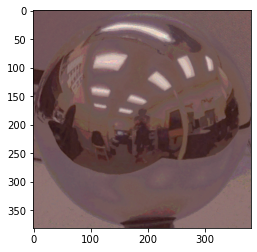

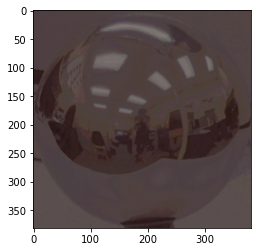

In [15]:
lm = 5
# get HDR image, log irradiance
calib_hdr_image, calib_log_irradiances, g = make_hdr_estimation(ldr_images, exposure_times, lm)

# write HDR image to directory
write_hdr_image(calib_hdr_image, 'images/outputs/calib_hdr.hdr')

# display HDR image
display_hdr_image(calib_hdr_image)


The following code displays your results. You can copy the resulting images and plots directly into your report where appropriate.

Min ratio =  0.11709837309021018   Max ratio =  7.035891027249931


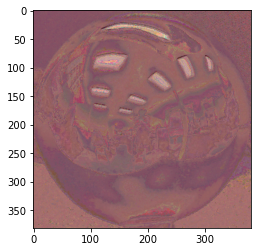

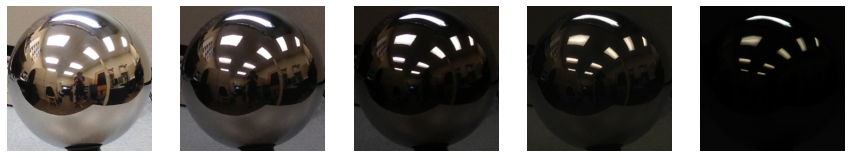

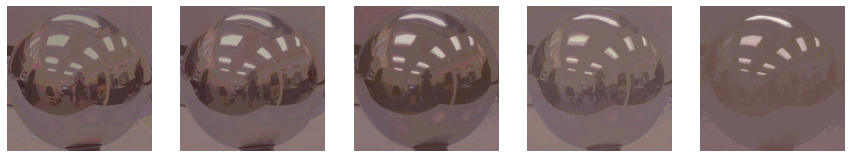

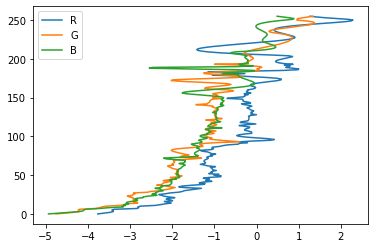

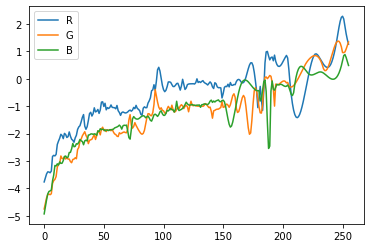

In [16]:
# display difference between calibrated and weighted
log_diff_im = np.log(calib_hdr_image/calib_hdr_image.mean())-np.log(weighted_hdr_image/weighted_hdr_image.mean())
print('Min ratio = ', np.exp(log_diff_im).min(), '  Max ratio = ', np.exp(log_diff_im).max())
plt.figure()
plt.imshow(rescale_images_linear(log_diff_im))

# display original images (code provided in utils.display)
display_images_linear_rescale(ldr_images)

# display log irradiance image (code provided in utils.display)
display_images_linear_rescale(calib_log_irradiances)

# plot g vs intensity, and then plot intensity vs g
N, NG = g.shape
labels = ['R', 'G', 'B']
plt.figure()
for n in range(N):
    plt.plot(g[n], range(NG), label=labels[n])
plt.gca().legend(('R', 'G', 'B'))

plt.figure()
for n in range(N):
    plt.plot(range(NG), g[n], label=labels[n])
plt.gca().legend(('R', 'G', 'B'))

naive:  	log range =  6.462 	avg RMS error =  0.527
weighted:	log range =  5.813 	avg RMS error =  5.602
calibrated:	log range =  8.029 	avg RMS error =  2.539


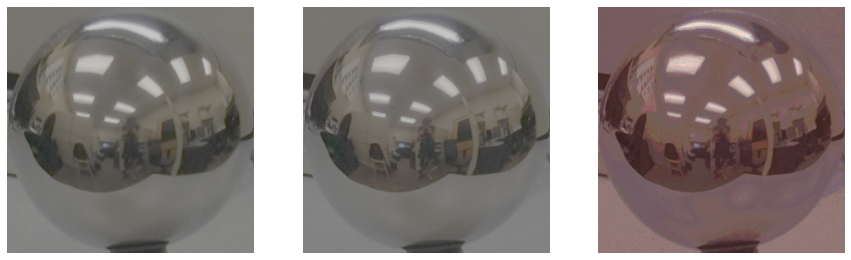

In [17]:
def weighted_log_error(ldr_images, hdr_image, log_irradiances):
    # computes weighted RMS error of log irradiances for each image compared to final log irradiance
    N, H, W, C = ldr_images.shape
    w = 1-abs(ldr_images - 0.5)*2
    err = 0
    for n in np.arange(N):
        err += np.sqrt(np.multiply(w[n], (log_irradiances[n]-np.log(hdr_image))**2).sum()/w[n].sum())/N 
    return err


# compare solutions
err = weighted_log_error(ldr_images, naive_hdr_image, naive_log_irradiances)
print('naive:  \tlog range = ', round(np.log(naive_hdr_image).max() - np.log(naive_hdr_image).min(),3), '\tavg RMS error = ', round(err,3))
err = weighted_log_error(ldr_images, weighted_hdr_image, naive_log_irradiances)
print('weighted:\tlog range = ', round(np.log(weighted_hdr_image).max() - np.log(weighted_hdr_image).min(),3), '\tavg RMS error = ', round(err,3))
err = weighted_log_error(ldr_images, calib_hdr_image, calib_log_irradiances)
print('calibrated:\tlog range = ', round(np.log(calib_hdr_image).max() - np.log(calib_hdr_image).min(),3), '\tavg RMS error = ', round(err,3))

# display log hdr images (code provided in utils.display)
display_images_linear_rescale(np.log(np.stack((naive_hdr_image/naive_hdr_image.mean(), weighted_hdr_image/weighted_hdr_image.mean(), calib_hdr_image/calib_hdr_image.mean()), axis=0)))

## Panoramic transformations 

Compute the equirectangular image from the mirrorball image

In [ ]:
def panoramic_transform(hdr_image):
    '''
    Given HDR mirror ball image, 
    
    Expects mirror ball image to have center of the ball at center of the image, and
    width and height of the image to be equal.
    
    Steps to implement:
    1) Compute N image of normal vectors of mirror ball
    2) Compute R image of reflection vectors of mirror ball
    3) Map reflection vectors into spherical coordinates
    4) Interpolate spherical coordinate values into equirectangular grid.
    
    Steps 3 and 4 are implemented for you with get_equirectangular_image

    '''
    H, W, C = hdr_image.shape
    assert H == W
    assert C == 3

    # TO DO: compute N and R
        
    # R = V - 2 * dot(V,N) * N


    
    plt.imshow((N+1)/2)
    plt.show()
    plt.imshow((R+1)/2)
    plt.show()

    equirectangular_image = get_equirectangular_image(R, hdr_image)
    return equirectangular_image

In [ ]:
hdr_mirrorball_image = read_hdr_image('images/outputs/calib_hdr.hdr')
eq_image = panoramic_transform(hdr_mirrorball_image)

write_hdr_image(eq_image, 'images/outputs/equirectangular.hdr')

plt.figure(figsize=(15,15))
display_hdr_image(eq_image)


---

## Rendering synthetic objects into photographs 

Use Blender to render the scene with and with objects and obtain the mask image.  The code below should then load the images and create the final composite.

In [ ]:
# Read the images that you produced using Blender.  Modify names as needed.
O = read_image('images/proj4_objects.png')
E = read_image('images/proj4_empty.png')
M = read_image('images/proj4_mask.png')
M = M > 0.5
I = background_image
I = cv2.resize(I, (M.shape[1], M.shape[0]))

In [ ]:
# TO DO: compute final composite
result = []

plt.figure(figsize=(20,20))
plt.imshow(result)
plt.show()

write_image(result, 'images/outputs/final_composite.png')

In [ ]:
def make_hdr_filtered(ldr_images: np.ndarray, exposures: list) -> (np.ndarray, np.ndarray):
    '''
    Makes HDR image using multiple LDR images, and its corresponding exposure values.
    Please refer to problem notebook for how to do it.
    
    The steps to implement:
    1) compute weights for images with based on intensities for each exposures
        - This can be a binary mask to exclude low / high intensity values

    2) Divide each images by its exposure time.
        - This will rescale images as if it has been exposed for 1 second.
    
    3) Return weighted average of above images
    
    
    Args:
        ldr_images(np.ndarray): N x H x W x 3 shaped numpy array representing
            N ldr images with width W, height H, and channel size of 3 (RGB)
        exposures(list): list of length N, representing exposures of each images.
            Each exposure should correspond to LDR images' exposure value.
    Return:
        (np.ndarray): H x W x 3 shaped numpy array representing HDR image merged without
            under - over exposed regions
        (np.ndarray): N x H x W x 3 shaped numpy array represending log irradiances
            for each exposures
    '''
    N, H, W, C = ldr_images.shape
    print(N, H, W, C)
    # sanity check
    assert N == len(exposures)
    
    # TODO: Implement ldr_images + exposures -> HDR image function here
    w = np.vectorize(lambda z: float(128-abs(z-128)))
    
    hdr_image = np.zeros((H, W, C))
    sum_w = np.zeros((H, W, C))
    
    for i in range(N):
        weights = w(ldr_images[i])
        sum_w += weights
        hdr_image += (weights*ldr_images[i])/(exposures[i]*255)
        
    hdr_image /= sum_w

    log_irradiances = np.zeros((N, H, W, C))
    
    for i in range(N):
        log_irradiances[i] = np.log(ldr_images[i]/exposures[i])
    
    return hdr_image, log_irradiances
In [52]:
# get HDR image, log irradiance
filtered_hdr_image, filtered_log_irradiances = make_hdr_filtered(ldr_images, exposures)

# write HDR image to directory
write_hdr_image(filtered_hdr_image, 'images/outputs/filtered_hdr.hdr')

# display HDR image
display_hdr_image(filtered_hdr_image)

# display log irradiance image
display_log_irradiances(naive_log_irradiances)
3 700 700 3
/Users/kathie/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in log


LDR merging and response function estimation (15 points)
Nearly all cameras apply a non-linear function to recorded raw pixel values in order to better simulate human vision. In other words, the light incoming to the camera (radiance) is recorded by the sensor, and then mapped to a new value by this function. This function is called the film response function, and in order to convert pixel values to true radiance values, we need to estimate this response function. Typically the response function is hard to estimate, but since we have multiple observations at each pixel at different exposures, we can do a reasonable job up to a missing constant.

The method we will use to estimate the response function is outlined in this paper. Given pixel values Z at varying exposure times t, the goal is to solve for g(Z) = ln(R*t) = ln(R)+ln(t). This boils down to solving for R (irradiance) since all other variables are known. By these definitions, g is the inverse, log response function. The paper provides code to solve for g given a set of pixels at varying exposures (we also provide gsolve in utils). Use this code to estimate g for each image channel (r/g/b). Then, recover the HDR image using equation 6 in the paper.

Some hints on using gsolve:
When providing input to gsolve, don't use all available pixels, otherwise you will likely run out of memory / have very slow run times. To overcome, just randomly sample a set of pixels (100 or so can suffice), but make sure all pixel locations are the same for each exposure.
The weighting function w should be implemented using Eq. 4 from the paper (this is the same function that can be used for the previous LDR merging method, i.e. w = lambda z: float(128-abs(z-128))).
Try different lambda values for recovering g. Try lambda=1 initially, then solve for g and plot it. It should be smooth and continuously increasing. If lambda is too small, g will be bumpy.
Refer to Eq. 6 in the paper for using g and combining all of your exposures into a final image. Note that this produces log radiance values, so make sure to exponentiate the result and save absolute radiance.
In [61]:
def make_hdr_estimation(ldr_images: np.ndarray, exposures: list)-> (np.ndarray, np.ndarray):
    '''
    Makes HDR image using multiple LDR images, and its corresponding exposure values.
    Please refer to problem notebook for how to do it.
    
    The steps to implement:
    1) Create random points to sample (from mirror ball region)
    2) For each exposures, compute g values using samples
    3) Recover HDR image using g values
    
    Args:
        ldr_images(np.ndarray): N x H x W x 3 shaped numpy array representing
            N ldr images with width W, height H, and channel size of 3 (RGB)
        exposures(list): list of length N, representing exposures of each images.
            Each exposure should correspond to LDR images' exposure value.
    Return:
        (np.ndarray): H x W x 3 shaped numpy array representing HDR image merged using
            gsolve
        (np.ndarray): N x H x W x 3 shaped numpy array represending log irradiances
            for each exposures
        (np.ndarray): 3 x 256 shaped numpy array represending g values of each pixel intensities
            at each channels (used for plotting)
    '''
    N, H, W, _ = ldr_images.shape
    
    # sanity check
    assert N == len(exposures)
    
    # implement HDR estimation using gsolve
    
    w = lambda z: float(129-abs(z-128))

    hdr_image = np.zeros((H, W, 3))
    g_per_exposures = np.zeros((3, 256))
    
    log_exp = np.log(exposures)
        
    log_irradiances = np.zeros((N, H, W, 3))      
    
    w = np.vectorize(w)
    
    ys = np.random.randint(H, size=800)
    xs = np.random.randint(W, size=800)

    for c in range(3):
        
        g_per_exposures[c] = g_compute(ldr_images[:,:,:,c], w, 100, 800, xs, ys, log_exp).T
        funcg = np.vectorize(lambda x: g_per_exposures[c][int(x)])
        weights = np.zeros((H, W))
        num = np.zeros((H,W))
        
        for n in range(N):
            tmp_weights = w(ldr_images[n, :, :, c])
            num += tmp_weights*(funcg(ldr_images[n,:,:,c])-log_exp[n])
            log_irradiances[n,:,:,c] = funcg(ldr_images[n,:,:,c])-log_exp[n]
            weights += tmp_weights

        hdr_image[:, :, c] = num/weights
        
    hdr_image = abs(np.exp(hdr_image))

    return hdr_image, log_irradiances, g_per_exposures

def g_compute(ldr_images, w, l, p, xs, ys, B):
    '''
    Args:
        l: lambda
        p(int): length of the sample
        c(int): channel
    Return:
        g
    
    **IMPORTANT**
    The gsolve operations should be ran with:
        Z: int64 array of shape N x P, where N = number of images, P = number of pixels
        B: float32 array of shape N,
        l: Number
        W: function that takes int and returns float
    '''
    
    N, H, W = ldr_images.shape
    Z = np.zeros((N, p))
    for m in range(p):
        Z[:, m] = ldr_images[:, ys[m], xs[m]]
    Z = Z.astype(np.int64)

    g, lE = gsolve(Z, B, l, w)
    return g
In [62]:
# get HDR image, log irradiance
estimated_hdr_image, estimated_log_irradiance, estimated_g = make_hdr_estimation(ldr_images, exposures)

# write HDR image to directory
write_hdr_image(estimated_hdr_image, 'images/outputs/estimated_hdr.hdr')

# display HDR image
display_hdr_image(estimated_hdr_image)

# display log irradiance image
display_log_irradiances(estimated_log_irradiance)
/Users/kathie/Dropbox/cs445/proj4_materials/utils/hdr_helpers.py:62: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x = np.linalg.lstsq(A, b)[0]


In [55]:
display_hdr_image_linear(np.log(estimated_hdr_image))

In [56]:
# display G function for each intensity values
N, NG = estimated_g.shape
labels = ['R', 'G', 'B']
plt.figure()
for n in range(N):
    plt.plot(range(NG), estimated_g[n], label=labels[n])
plt.gca().legend(('R', 'G', 'B'))
Out[56]:
<matplotlib.legend.Legend at 0xb29716c88>

Panoramic transformations (20 pts)
Now that we have an HDR image of the spherical mirror, we'd like to use it for relighting (i.e. image-based lighting). However, many programs don't accept the "mirror ball" format, so we need to convert it to a different 360 degree, panoramic format (there is a nice overview of many of these formats here). For this part of the project, you should implement the mirror ball to equirectangular (latitude longitude) transformation. Most rendering software accepts this format, including Blender's Cycles renderer, which is what we'll use in the next part of the project.

To perform the transformation, you need to figure out the mapping between the mirrored sphere domain and the equirectangular domain. Hint: calculate the normals of the sphere (N) and assume the viewing direction (V) is constant. You can calculate reflection vectors with R = V - 2 dot(V,N) N, (NOTE that you'd have to implement channel-wise dot product). which is the direction that light is incoming from the world to the camera after bouncing off the sphere. The reflection vectors can then be converted to, providing the latitude and longitude (phi and theta) of the given pixel (fixing the distance to the origin, r, to be 1). Note that this assumes an orthographic camera (which is a close approximation as long as the sphere isn't too close to the camera).

Next, the equirectangular domain can be created by making an image in which the rows correspond to theta and columns correspond to phi in spherical coordinates, e.g.

EH, EW = 360, 720
phi_fst_half = np.arange(math.pi, 2*math.pi, math.pi / (EW // 2))
phi_snd_half = np.arange(0 * math.pi, math.pi, math.pi / (EW // 2))

theta_range = np.arange(0, math.pi, math.pi / EH)
phi_ranges = np.concatenate((phi_fst_half, phi_snd_half))
phis, thetas = np.meshgrid(phi_ranges, theta_range)
Note that by choosing 360 as EH and 720 as EW, we are making every pixel in equirectangular image to correspond to area occupied by 0.5 degree x 0.5 degree in spherical coordinate. Now that you have the phi/theta for both the mirror ball image and the equirectangular domain, use scipy's scipy.interpolate.griddata function to perform the transformation. Below is an example transformation.

Note that the following portion of the project depends on successfully converting your mirror ball HDR image to the equirectangular domain. If you cannot get this working, you can request code from the instructors at a 20 point penalty (i.e. no points will be awarded for this section, but you can do the later sections).

In [57]:
hdr_mirrorball_image = read_hdr_image('images/outputs/estimated_hdr.hdr')
In [114]:
def panoramic_transform(hdr_image):
    '''
    Given HDR mirror ball image, 
    
    Expects mirror ball image to have center of the ball at center of the image, and
    width and height of the image to be equal.
    
    Steps to implement:
    1) Compute normal vector from mirror ball
    2) Compute reflection vector of mirror ball using given equation
    3) Map reflection vectors into spherical coordinates
    4) Interpolate spherical coordinate values into equirectangular grid.
      - hint: use scipy.interpolate.griddata


    '''
    H, W, C = hdr_image.shape
    assert H == W
    assert H % 2 == 0
    assert C == 3
    R = H // 2
    
    # get equirectangular image somehow
    phi = np.zeros((H, W))
    theta = np.zeros((H, W))
    
    n = 0
    for i in range(H):
        for j in range(W):

            reflect = reflection_compute(i, j, R)
            
            if sum(np.square(reflect)) == 0:
                phi[i, j] = 0
                theta[i, j] = 0
            else:
                phi[i, j] = math.atan2(reflect[0], reflect[2])
                theta[i, j] = math.acos(reflect[1])
                n += 1
                
    phi %= math.pi*2
    
    print("phi theta")
    
    HDR_R = np.zeros(n)
    HDR_G = np.zeros(n)
    HDR_B = np.zeros(n)
    points = np.zeros((n, 2))
    counter = 0
    for i in range(H):
        for j in range(W):
            if (phi[i, j] == 0 and theta[i, j] == 0):
                continue
            points[counter, 0] = theta[i, j]
            points[counter, 1] = phi[i, j]
            HDR_R[counter] = hdr_image[i, j, 0]
            HDR_G[counter] = hdr_image[i, j, 1]
            HDR_B[counter] = hdr_image[i, j, 2]
            counter += 1
    

    '''
    Viewing direction : 0, 0, 1
    X: right, Y: up
    Phi: atan2(RX, RZ)
    Theta: arccos(RY)
    Equirectangular image:
    Phi: [PI - 2PI][0 - PI]
    Theta: 0 - PI
    '''
    EH, EW = 360, 720
    phi_fst_half = np.arange(math.pi, 2*math.pi, math.pi / (EW // 2))
    phi_snd_half = np.arange(0 * math.pi, math.pi, math.pi / (EW // 2))
    theta_range = np.arange(0, math.pi, math.pi / EH)
    phi_ranges = np.concatenate((phi_fst_half, phi_snd_half))
    phis, thetas = np.meshgrid(phi_ranges, theta_range)
    
    xi = np.zeros((360 * 720, 2))
    counter = 0
    for i in range(360):
        for j in range(720):
            xi[counter, 0] = thetas[i, j]
            xi[counter, 1] = phis[i, j]
            counter += 1
    
    '''
    griddata((theta, phi), hdr_image, (theta_out, phi_out))
    You should make your input shapes into:
    points: n x 2
    values: n x 0 (or (n,) in numpy shape representation)
    xi: M x 2
    Here, n should be number of pixels on the mirror ball(roughly PI * R^2, where R = W // 2)
    M should be your equirectangular image size (360 * 720 = 259200)
    gridData will then return Mx0 shaped array, which then you have to resize into 360 x 720
    '''
    equirectangular_R = np.reshape(griddata(points, HDR_R, xi, method='linear'), (360, 720))
    equirectangular_G = np.reshape(griddata(points, HDR_G, xi, method='linear'), (360, 720))
    equirectangular_B = np.reshape(griddata(points, HDR_B, xi, method='linear'), (360, 720))
    
    
    equirectangular_image = np.zeros((360, 720,3))
    equirectangular_image[:,:,0] = equirectangular_R
    equirectangular_image[:,:,1] = equirectangular_G
    equirectangular_image[:,:,2] = equirectangular_B
    return equirectangular_image


def reflection_compute(col, row, r):
    nx = (row - r) / r
    ny = -(col - r) / r
    if (np.square(nx) + np.square(ny) >= 1):
        nx = 0
        ny = 0
        nz = 0
    else:
        nz = - math.sqrt(1 - np.square(nx) - np.square(ny))

    N = np.array([nx, ny, nz])
    
    result = np.zeros(3)
    if (np.square(nx) + np.square(ny) + np.square(nz) != 0):

        V = np.array([0, 0, 1])
        R = V - 2 * np.dot(V, N) * N
        Rn = np.linalg.norm(R)
        result = R / Rn

    return result
In [115]:
eq_image = panoramic_transform(naive_hdr_image)
display_hdr_image(eq_image)
write_hdr_image(eq_image, 'images/outputs/equirectangular.hdr')
phi theta
Warning: Negative / Inf values found in hdr image. Clamping to nearest valid value
/Users/kathie/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)

In [60]:
display_hdr_image_linear(np.log(eq_image))
/Users/kathie/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)

In [ ]:
def make_hdr_filtered(ldr_images: np.ndarray, exposures: list) -> (np.ndarray, np.ndarray):
    '''
    Makes HDR image using multiple LDR images, and its corresponding exposure values.
    Please refer to problem notebook for how to do it.
    
    The steps to implement:
    1) compute weights for images with based on intensities for each exposures
        - This can be a binar values range in [0,2y mask to exclude low / high intensity values

    2) Divide each images by its exposure time.
        - This will rescale images as if it has been exposed for 1 second.
    
    3) Return weighted average of above images
    
    
    Args:
        ldr_images(np.ndarray): N x H x W x 3 shaped numpy array representing
            N ldr images with width W, height H, and channel size of 3 (RGB)
        exposures(list): list of length N, representing exposures of each images.
            Each exposure should correspond to LDR images' exposure value.
    Return:
        (np.ndarray): H x W x 3 shaped numpy array representing HDR image merged without
            under - over exposed regions
        (np.ndarray): N x H x W x 3 shaped numpy array represending log irradiances
            for each exposures
    '''
    w = lambda z: 128 - np.abs(z - 128)
    
    N, H, W, C = ldr_images.shape
    # sanity check
    assert N == len(exposures)
    
    # TODO: Implement ldr_images + exposures -> HDR image function here
    
    ldr_scaled = ldr_images*255.0
    
    hdr_image = np.zeros((H,W,C))
    log_irradiances = np.zeros((N,H,W,C))
    total_mask = 0
    for n in range(N):
        mask = w(ldr_scaled[n,:,:,:])
        total_mask += mask
        hdr_image += (mask*ldr_scaled[n,:,:,:])/exposures[n]
        log_irradiances[n,:,:,:] = np.log1p(ldr_scaled[n,:,:,:]/exposures[n]) - np.log(exposures[n])
    hdr_image /= total_mask
    
    mini = np.min(log_irradiances)
    maxi = np.max(log_irradiances)
    log_irradiances = (log_irradiances-mini)/(maxi-mini)
    
    return hdr_image, log_irradiances
In [17]:
# get HDR image, log irradiance
filtered_hdr_image, filtered_log_irradiances = make_hdr_filtered(ldr_images, exposures)

# write HDR image to directory
write_hdr_image(filtered_hdr_image, 'images/outputs/filtered_hdr.hdr')

# display HDR image
display_hdr_image(filtered_hdr_image)

# display log irradiance image
display_log_irradiances(naive_log_irradiances)
C:\Users\nikhi.000\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide
Warning: Negative / Inf values found in hdr image. Clamping to nearest valid value


LDR merging and response function estimation (15 points)
Nearly all cameras apply a non-linear function to recorded raw pixel values in order to better simulate human vision. In other words, the light incoming to the camera (radiance) is recorded by the sensor, and then mapped to a new value by this function. This function is called the film response function, and in order to convert pixel values to true radiance values, we need to estimate this response function. Typically the response function is hard to estimate, but since we have multiple observations at each pixel at different exposures, we can do a reasonable job up to a missing constant.

The method we will use to estimate the response function is outlined in this paper. Given pixel values Z at varying exposure times t, the goal is to solve for g(Z) = ln(R*t) = ln(R)+ln(t). This boils down to solving for R (irradiance) since all other variables are known. By these definitions, g is the inverse, log response function. The paper provides code to solve for g given a set of pixels at varying exposures (we also provide gsolve in utils). Use this code to estimate g for each image channel (r/g/b). Then, recover the HDR image using equation 6 in the paper.

Some hints on using gsolve:
When providing input to gsolve, don't use all available pixels, otherwise you will likely run out of memory / have very slow run times. To overcome, just randomly sample a set of pixels (100 or so can suffice), but make sure all pixel locations are the same for each exposure.
The weighting function w should be implemented using Eq. 4 from the paper (this is the same function that can be used for the previous LDR merging method, i.e. w = lambda z: float(128-abs(z-128))).
Try different lambda values for recovering g. Try lambda=1 initially, then solve for g and plot it. It should be smooth and continuously increasing. If lambda is too small, g will be bumpy.
Refer to Eq. 6 in the paper for using g and combining all of your exposures into a final image. Note that this produces log radiance values, so make sure to exponentiate the result and save absolute radiance.
In [18]:
def make_hdr_estimation(ldr_images: np.ndarray, exposures: list)-> (np.ndarray, np.ndarray):
    '''
    Makes HDR image using multiple LDR images, and its corresponding exposure values.
    Please refer to problem notebook for how to do it.
    
    **IMPORTANT**
    The gsolve operations should be ran with:
        Z: int64 array of shape N x P, where N = number of images, P = number of pixels
        B: float32 array of shape N,
        l: Number
        W: function that takes int and returns float
    
    The steps to implement:
    1) Create random points to sample (from mirror ball region)
    2) For each exposures, compute g values using samples
    3) Recover HDR image using g values
    

    Args:
        ldr_images(np.ndarray): N x H x W x 3 shaped numpy array representing
            N ldr images with width W, height H, and channel size of 3 (RGB)
        exposures(list): list of length N, representing exposures of each images.
            Each exposure should correspond to LDR images' exposure value.
    Return:
        (np.ndarray): H x W x 3 shaped numpy array representing HDR image merged using
            gsolve
        (np.ndarray): N x H x W x 3 shaped numpy array represending log irradiances
            for each exposures
        (np.ndarray): 3 x 256 shaped numpy array represending g values of each pixel intensities
            at each channels (used for plotting)
    '''    
    N, H, W, C = ldr_images.shape
    # sanity check
    assert N == len(exposures)
    
    # implement HDR estimation using gsolve
    
    ldr_scaled = ldr_images*255.0
    
    hdr_image = np.zeros((H,W,C))
    log_irradiances = np.zeros((N,H,W,C))
    g_per_exposures = np.zeros((C,256))
        
    randsize = 150
    randrows = np.random.randint(H, size=randsize)
    randcols = np.random.randint(W, size=randsize)
    
    Z = np.zeros((N,randsize))
    B = np.log(exposures)
    l = 10
    w = lambda z: 128 - np.abs(z - 128)
    
    for c in range(C):
        
        for n in range(N):
            for i in range(randsize):
                Z[n,i] = ldr_scaled[n,randrows[i],randcols[i],c]
            
        g, le = gsolve(Z.astype("uint8"),B,l,w)
        g_per_exposures[c] = g
        
        for i in range(H):
            for j in range(W):
                num = 0
                den = 0
                for n in range(N):
                    z = int(ldr_scaled[n,i,j,c])
                    num += w(z)*(g[z]-B[n])
                    den += w(z)
                    log_irradiances[n,i,j,c] = g[z] - B[n]
                hdr_image[i,j,c] = num/den
                
    mini = np.min(log_irradiances)
    maxi = np.max(log_irradiances)
    log_irradiances = (log_irradiances-mini)/(maxi-mini)
        
    return np.exp(hdr_image), log_irradiances, g_per_exposures
In [27]:
# get HDR image, log irradiance
estimated_hdr_image, estimated_log_irradiance, estimated_g = make_hdr_estimation(ldr_images, exposures)

# write HDR image to directory
write_hdr_image(estimated_hdr_image, 'images/outputs/estimated_hdr.hdr')

# display HDR image
display_hdr_image(estimated_hdr_image)

# display log irradiance image
display_log_irradiances(estimated_log_irradiance)
C:\Users\nikhi.000\Anaconda3\lib\site-packages\ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in double_scalars
Warning: Negative / Inf values found in hdr image. Clamping to nearest valid value


In [28]:
# display G function for each intensity values
N, NG = estimated_g.shape
labels = ['R', 'G', 'B']
plt.figure()
for n in range(N):
    plt.plot(range(NG), estimated_g[n], label=labels[n])
plt.gca().legend(('R', 'G', 'B'))
Out[28]:
<matplotlib.legend.Legend at 0x2008401ec88>

Panoramic transformations (20 pts)
Now that we have an HDR image of the spherical mirror, we'd like to use it for relighting (i.e. image-based lighting). However, many programs don't accept the "mirror ball" format, so we need to convert it to a different 360 degree, panoramic format (there is a nice overview of many of these formats here). For this part of the project, you should implement the mirror ball to equirectangular (latitude longitude) transformation. Most rendering software accepts this format, including Blender's Cycles renderer, which is what we'll use in the next part of the project.

To perform the transformation, you need to figure out the mapping between the mirrored sphere domain and the equirectangular domain. Hint: calculate the normals of the sphere (N) and assume the viewing direction (V) is constant. You can calculate reflection vectors with R = V - 2 dot(V,N) N, (NOTE that you'd have to implement channel-wise dot product). which is the direction that light is incoming from the world to the camera after bouncing off the sphere. The reflection vectors can then be converted to, providing the latitude and longitude (phi and theta) of the given pixel (fixing the distance to the origin, r, to be 1). Note that this assumes an orthographic camera (which is a close approximation as long as the sphere isn't too close to the camera).

Next, the equirectangular domain can be created by making an image in which the rows correspond to theta and columns correspond to phi in spherical coordinates, e.g.

EH, EW = 360, 720
phi_fst_half = np.arange(math.pi, 2*math.pi, math.pi / (EW // 2))
phi_snd_half = np.arange(0 * math.pi, math.pi, math.pi / (EW // 2))

theta_range = np.arange(0, math.pi, math.pi / EH)
phi_ranges = np.concatenate((phi_fst_half, phi_snd_half))
phis, thetas = np.meshgrid(phi_ranges, theta_range)

Note that by choosing 360 as EH and 720 as EW, we are making every pixel in equirectangular image to correspond to area occupied by 0.5 degree x 0.5 degree in spherical coordinate. Now that you have the phi/theta for both the mirror ball image and the equirectangular domain, use scipy's scipy.interpolate.griddata function to perform the transformation. Below is an example transformation.

Note that the following portion of the project depends on successfully converting your mirror ball HDR image to the equirectangular domain. If you cannot get this working, you can request code from the instructors at a 20 point penalty (i.e. no points will be awarded for this section, but you can do the later sections).

In [7]:
hdr_mirrorball_image = read_hdr_image('images/outputs/estimated_hdr.hdr')
display_hdr_image(hdr_mirrorball_image)
Warning: Negative / Inf values found in hdr image. Clamping to nearest valid value

In [8]:
def panoramic_transform(hdr_image):
    '''
    Given HDR mirror ball image, 
    
    Expects mirror ball image to have center of the ball at center of the image, and
    width and height of the image to be equal.
    
    Steps to implement:
    1) Compute normal vector from mirror ball
    2) Compute reflection vector of mirror ball using given equation
    3) Map reflection vectors into spherical coordinates
    4) Interpolate spherical coordinate values into equirectangular grid.
      - hint: use scipy.interpolate.griddata


    '''
    H, W, C = hdr_image.shape
    assert H == W
    assert H % 2 == 0
    assert C == 3
    R = H // 2
    
    X, Y = np.meshgrid(range(W), range(H))
    X = (X-W/2)/(W/2)
    Y = -(Y-H/2)/(H/2)
    Z = np.sqrt(1-np.clip(X*X + Y*Y,a_min=0,a_max=1))
    mask = np.where(Z > 0, 1, 0);
    X *= mask
    Y *= mask
    
    N = np.zeros((H,W,C))
    N[:,:,0] = X
    N[:,:,1] = Y
    N[:,:,2] = Z
    
    V = np.zeros((H,W,C))
    V[:,:,2] = -1*mask
    R = np.zeros((H,W,C))
    for c in range(C):
        R[:,:,c] = V[:,:,c]+2 * Z * N[:,:,c]
        
    theta_ball = np.arccos(R[:,:,1]) * mask
    phi_ball = np.arctan2(R[:,:,2], R[:,:,0]) - np.pi/2
    phi_ball %= 2*np.pi
    phi_ball *= mask
    
    phi_ball = phi_ball.reshape((H*W))
    theta_ball = theta_ball.reshape((H*W))
    hdr_image = hdr_image.reshape((H*W,C))
    
    EH, EW = 360, 720
    phi_fst_half = np.arange(0, math.pi, math.pi / (EW // 2))
    phi_snd_half = np.arange(math.pi, 2*math.pi, math.pi / (EW // 2))

    theta_range = np.arange(0, math.pi, math.pi / EH)
    phi_ranges = np.concatenate((phi_fst_half, phi_snd_half))
    phis, thetas = np.meshgrid(phi_ranges, theta_range)
    
    # get equirectangular image somehow
    equirectangular_image = griddata((phi_ball,theta_ball), hdr_image, (phis, thetas))
    return equirectangular_image.astype(np.float32)
In [9]:
eq_image = panoramic_transform(naive_hdr_image)
display_hdr_image(eq_image)
write_hdr_image(eq_image, 'images/outputs/equirectangular.hdr')
---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
<ipython-input-9-cd74ee8380cb> in <module>
----> 1 eq_image = panoramic_transform(naive_hdr_image)
      2 display_hdr_image(eq_image)
      3 write_hdr_image(eq_image, 'images/outputs/equirectangular.hdr')

NameError: name 'naive_hdr_image' is not defined


In [25]:
# this part assumes that you have these from Blender.
blender_output_with_object_path = "images/outputs/render_render2.png"
blender_output_without_object_path = "images/outputs/render_empty2.png"
blender_output_mask_path = "images/outputs/render_mask2.png"

R = read_image(blender_output_with_object_path)
E = read_image(blender_output_without_object_path)
M = read_image(blender_output_mask_path)
M = M > 0.5
I = background_image
In [26]:
merged = (M*R + (1-M)*I + (1-M)*(R-E)*0.75).astype(np.float32)
In [27]:
write_image(merged, 'images/outputs/merged.png')
plt.figure()
plt.imshow(merged)

---


## Bells & Whistles (Extra Points)

### Additional Image-Based Lighting Result 


### Other panoramic transformations 


### Photographer/tripod removal 


### Local tonemapping operator 

